In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import random
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import  Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

In [2]:
def process_data(x,y): ##x,y均为dataframe，并且y.columns=‘y’并且y的label为[0,1]
    shufflerange = list(range(len(x)))
    random.shuffle(shufflerange)
    shuffledx = x.loc[shufflerange]
    shuffledx.index = np.arange(0,len(shuffledx))
    shuffledy = y.loc[shufflerange]
    shuffledy.index = shuffledx.index
    return shuffledx,shuffledy

def generate_data(x,y,total_sum): ##在process_data进行之后扩充值total_sum数量
    x1 = x
    y1 = y
    len_generate = int(total_sum / len(x)) + 1
    for i in range(0,len_generate):
        x = pd.concat([x,x1],axis=0)
        y = pd.concat([y,y1],axis=0)
    x.index = np.arange(0,len(x))
    y.index = x.index
    return x,y

In [8]:
def model_init():
    clflg = SGDClassifier(loss='log')
    clfsgd = SGDClassifier()
    clfbn = BernoulliNB()
    clfpe = Perceptron()
    clfpac = PassiveAggressiveClassifier()
    model = [clflg,clfsgd,clfbn,clfpe,clfpac]
    model_name = ['Logistic','SVM','Bernoulli','Perceptron','PassiveAggressive']
    return model,model_name

In [9]:
##计算各个层之间的权重
def cal_weight(weight,yitazt,zt,j,yita):
    sum_he = np.dot(np.array(weight),np.exp(yitazt)) ##计算分母
    weight[j] = (weight[j] * np.exp((-yita)*zt[j]))/(sum_he) ##计算权重
    return weight

In [10]:
##初始化参数
def parameter_init(base_model,x,yita):
    n = len(base_model)
    model_plot_data_small = [[0]*len(x) for _ in range(n)]
    weight = [1/n]*n
    zt = [0]*n
    yitazt = [x*(-yita) for x in zt]
    base_model_end = [0]*n
    vote_count = 0
    base_model_count = [0]*n    
    vote_count_small = []
    return n,model_plot_data_small,weight,zt,yitazt,base_model_end,vote_count,base_model_count,vote_count_small

In [25]:
def build_model(x,y,yita_l):
    model_plot_data_big = []
    vote_list = []##存储总的分数
    vote_count_big = []
    for yita_order,yita in enumerate(yita_l):
        ##模型初始化，每一个yita对应一个组合分类器
        base_model,base_model_name = model_init()
        ##参数设定，初始化
        n,model_plot_data_small,weight,zt,yitazt,base_model_end,vote_count,base_model_count,vote_count_small = parameter_init(base_model,x,yita)
        ##循环迭代一步一步增加样本
        for i in range(0,len(x)):
            if(i%(int(len(x)/10))==0):
                print('已完成{}%'.format(i/(int(len(x)/10))*10))
            for j in range(0,n):
                clf = base_model[j]
                clf.partial_fit(np.array(x.loc[i]).reshape(1,-1),y['y'].loc[i].ravel(),classes=np.unique(y)) ##增量学习
                if i!=len(x)-1:
                    weight = cal_weight(weight,yitazt,zt,j,yita) ##计算权重函数
                    single_pre = clf.predict(np.array(x.loc[i+1]).reshape(1,-1)) ##对下一个样本的预测
                    base_model_end[j] = single_pre[0]  
                    if single_pre==y['y'].loc[i+1]:
                        base_model_count[j] += 1  ##基分类器正确数量统计
                        zt[j] = 0
                    else:
                        zt[j] = 1
                    model_plot_data_small[j][i] = base_model_count[j]/(i+1)
            if i!=len(x)-1:
                label_vote = np.dot(base_model_end,weight) ##由基分类器以及权重计算总分类器对下一个样本的计算值
                if label_vote>0.5:
                    label = 1
                else:
                    label = 0
                if label==y['y'].loc[i+1]:
                    vote_count += 1 ##计算总分类器的正确数量
                vote_count_small.append(vote_count/(i+1))
        
        count_t = [round(m / len(x),4) for m in base_model_count]
        vote = round(vote_count/len(x),4)
        if((vote>np.array(count_t)).all()):
            print('当前yita:',yita,'基分类器准确率',count_t,'组合分类器准确率',vote,'组合分类器更优')
        else:
            print('当前yita:',yita,'基分类器准确率',count_t,'组合分类器准确率',vote,'组合分类器一般')
        model_plot_data_big.append(model_plot_data_small)
        vote_list.append(vote)
        vote_count_big.append(vote_count_small)
    max_index = vote_list.index(max(vote_list))
    for i in range(0,n):
        model_plot_data_big[max_index][i].pop()
        plt.plot(np.arange(0,len(model_plot_data_big[max_index][i])),model_plot_data_big[max_index][i],'-.',alpha=0.3,label=base_model_name[i])
    vote_count_big[max_index].pop()
    plt.plot(np.arange(0,len(vote_count_big[max_index])),vote_count_big[max_index],'-.',alpha=0.8,label='Combine')
    plt.title('Best yita:{},End_socre:{}'.format(yita_l[max_index],vote_list[max_index]))
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy')
    plt.legend()            
    plt.grid(alpha=0.2) 
    plt.show()
    

已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.001 基分类器准确率 [0.8642, 0.852, 0.862, 0.852, 0.8878] 组合分类器准确率 0.8888 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.004 基分类器准确率 [0.8642, 0.852, 0.862, 0.852, 0.8878] 组合分类器准确率 0.889 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.008 基分类器准确率 [0.8642, 0.852, 0.862, 0.852, 0.8878] 组合分类器准确率 0.9002 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.01 基分类器准确率 [0.8642, 0.852, 0.862, 0.852, 0.8878] 组合分类器准确率 0.9008 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.02 基分类器准确率 [0.8642, 0.852, 0.862, 0.852, 0.8878] 组合分类器准确率 0.885 组合分类器一般


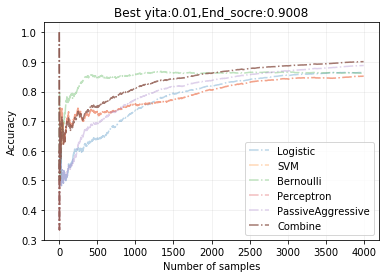

In [26]:
##方圆数据集
data = pd.read_csv('train.csv')
data.drop(['id'],axis=1,inplace=True)
y = data.loc[:,data.columns=='y']
x = data.loc[:,data.columns!='y']
#,0.008,0.01,0.02
y.columns = ['y']

yita_l = [0.001,0.004,0.008,0.01,0.02]
x,y = process_data(x,y)
x,y = generate_data(x,y,10000)
build_model(x,y,yita_l)

已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.001 基分类器准确率 [0.9353, 0.9321, 0.8702, 0.9321, 0.9631] 组合分类器准确率 0.9575 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.004 基分类器准确率 [0.9353, 0.9321, 0.8702, 0.9321, 0.9631] 组合分类器准确率 0.9612 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.008 基分类器准确率 [0.9353, 0.9321, 0.8702, 0.9321, 0.9631] 组合分类器准确率 0.9649 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.01 基分类器准确率 [0.9353, 0.9321, 0.8702, 0.9321, 0.9631] 组合分类器准确率 0.9653 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.02 基分类器准确率 [0.9353, 0.9321, 0.8702, 0.9321, 0.9631] 组合分类器准确率 0.9617 组合分类器一般


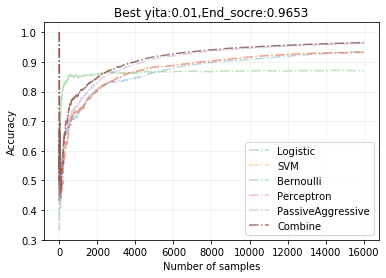

In [27]:
##方圆数据集
data = pd.read_csv('circle_square_train.csv')
data.drop(['id'],axis=1,inplace=True)
y = data.loc[:,data.columns=='y']
x = data.loc[:,data.columns!='y']
#,0.008,0.01,0.02
y.columns = ['y']

yita_l = [0.001,0.004,0.008,0.01,0.02]
x,y = process_data(x,y)
x,y = generate_data(x,y,10000)
build_model(x,y,yita_l)

已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
已完成100.0%
当前yita: 0.001 基分类器准确率 [0.9969, 0.9975, 0.9179, 0.9975, 0.998] 组合分类器准确率 0.9981 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
已完成100.0%
当前yita: 0.004 基分类器准确率 [0.9969, 0.9975, 0.9179, 0.9975, 0.998] 组合分类器准确率 0.9981 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
已完成100.0%
当前yita: 0.008 基分类器准确率 [0.9969, 0.9975, 0.9179, 0.9975, 0.998] 组合分类器准确率 0.9981 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
已完成100.0%
当前yita: 0.01 基分类器准确率 [0.9969, 0.9975, 0.9179, 0.9975, 0.998] 组合分类器准确率 0.9981 组合分类器更优
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
已完成100.0%
当前yita: 0.02 基分类器准确率 [0.9969, 0.9975, 0.9179, 0.9975, 0.998] 组合分类器准确率 0.9981 组合分类器更优


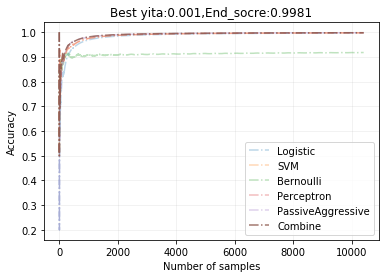

In [28]:
from sklearn import datasets
np.random.seed(2019)
data = datasets.load_digits()
##digig手写数字数据集【挑出两类】
x = data['data']
y = data['target']
x = pd.DataFrame(np.concatenate([x[y==1],x[y==2]]))
y = pd.DataFrame(np.concatenate([y[y==1],y[y==2]]))
y.columns = ['y']
y['y'].replace(2,0,inplace=True)

yita_l = [0.001,0.004,0.008,0.01,0.02]
x,y = process_data(x,y)
x,y = generate_data(x,y,10000)
build_model(x,y,yita_l)

已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.001 基分类器准确率 [0.9805, 0.9807, 0.9766, 0.9807, 0.9865] 组合分类器准确率 0.9854 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.004 基分类器准确率 [0.9805, 0.9807, 0.9766, 0.9807, 0.9865] 组合分类器准确率 0.9854 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.008 基分类器准确率 [0.9805, 0.9807, 0.9766, 0.9807, 0.9865] 组合分类器准确率 0.9854 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.01 基分类器准确率 [0.9805, 0.9807, 0.9766, 0.9807, 0.9865] 组合分类器准确率 0.9852 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.02 基分类器准确率 [0.9805, 0.9807, 0.9766, 0.9807, 0.9865] 组合分类器准确率 0.9862 组合分类器一般


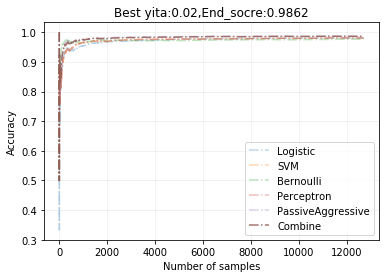

In [29]:
##MNIST 1 2 数据集
data = pd.read_csv('mnist_train.csv')
x = data.loc[:,data.columns!='label']
y = data.loc[:,data.columns=='label']
y.columns = ['y']
x = pd.concat([x.loc[y['y']==2],x.loc[y['y']==1]],axis=0)
x.index = np.arange(len(x))
y = pd.concat([y.loc[y['y']==2],y.loc[y['y']==1]],axis=0)
y.index = x.index
y['y'].replace(2,0,inplace=True)
yital = [0.0001,0.001,0.004,0.007,0.07,0.2]
x,y = process_data(x,y)
build_model(x,y,yita_l)


已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.0001 基分类器准确率 [0.9969, 0.9969, 0.9942, 0.9969, 0.9983] 组合分类器准确率 0.9978 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.001 基分类器准确率 [0.9969, 0.9969, 0.9942, 0.9969, 0.9983] 组合分类器准确率 0.9978 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.004 基分类器准确率 [0.9969, 0.9969, 0.9942, 0.9969, 0.9983] 组合分类器准确率 0.9978 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.007 基分类器准确率 [0.9969, 0.9969, 0.9942, 0.9969, 0.9983] 组合分类器准确率 0.9978 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.07 基分类器准确率 [0.9969, 0.9969, 0.9942, 0.9969, 0.9983] 组合分类器准确率 0.9983 组合分类器一般
已完成0.0%
已完成10.0%
已完成20.0%
已完成30.0%
已完成40.0%
已完成50.0%
已完成60.0%
已完成70.0%
已完成80.0%
已完成90.0%
当前yita: 0.2 基分类器准确率 [0.9969, 0.

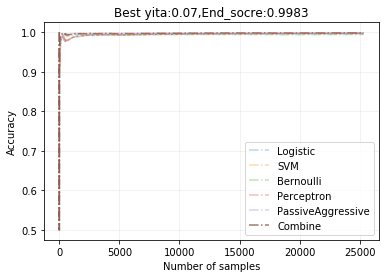

In [33]:
##MNIST 0 1 数据集
data = pd.read_csv('mnist_train.csv')
x = data.loc[:,data.columns!='label']
y = data.loc[:,data.columns=='label']
y.columns = ['y']
x = pd.concat([x.loc[y['y']==0],x.loc[y['y']==1]],axis=0)
x.index = np.arange(len(x))

y = pd.concat([y.loc[y['y']==0],y.loc[y['y']==1]],axis=0)
y.index = x.index
yita_l = [0.0001,0.001,0.004,0.007,0.07,0.2]
x,y = process_data(x,y)
x,y = generate_data(x,y,10000)
build_model(x,y,yita_l)